In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [13]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "../data/PetImages/Cat"
    DOGS = "../data/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    training_images = []
    training_labels = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                    except Exception as e:
                        pass

        np.random.shuffle(self.training_data)
        
        self.training_images = [v[0] for v in self.training_data]
        self.training_labels = [v[1] for v in self.training_data]
        
        np.save("training_images.npy", self.training_images)
        np.save("training_labels.npy", self.training_labels)
        
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [14]:
training_images = np.load("training_images.npy", allow_pickle=True)
training_labels = np.load("training_labels.npy", allow_pickle=True)

print(len(training_images), len(training_labels))

24946 24946


In [15]:
import torch

In [16]:
X = torch.Tensor(training_images).view(-1,50,50)
X = X/255.0
X.shape

torch.Size([24946, 50, 50])

In [17]:
y = torch.Tensor(training_labels)
y.shape

torch.Size([24946, 2])

tensor([0., 1.])

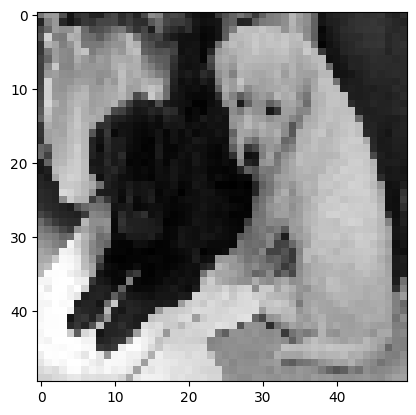

In [19]:
import matplotlib.pyplot as plt

i = 14
plt.imshow(X[i], cmap="gray")
y[i]

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

In [23]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [25]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [26]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [27]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

22452 2494


In [28]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]


        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████████████████████████████████████████████████████████████████████████████| 225/225 [01:07<00:00,  3.32it/s]

Epoch: 0. Loss: 0.17212572693824768


In [30]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 3))

100%|███████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:04<00:00, 579.60it/s]

Accuracy:  0.716
